This notebook demonstrates the basics of Bayesian estimation of the general linear model.  This presentation is based on material from http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/ .  First let's generate some data for a simple design.

In [1]:
import os,sys
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../')
from utils.mkdesign import create_design_singlecondition
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
from statsmodels.tsa.arima_process import arma_generate_sample
import scipy.stats
import pymc3

tslength=300
d,design=create_design_singlecondition(blockiness=1.0,deslength=tslength,
                                       blocklength=20,offset=20)
regressor,_=compute_regressor(design,'spm',numpy.arange(0,tslength))


ar1_noise=arma_generate_sample([1,0.3],[1,0.],len(regressor))

X=numpy.hstack((regressor,numpy.ones((len(regressor),1))))
beta=numpy.array([4,100])
noise_sd=10
data = X.dot(beta) + ar1_noise*noise_sd

../utils/mkdesign.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  design[b:b+blocklength]=1


First estimate the model using ordinary least squares

In [2]:
beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data)
resid=data - X.dot(beta_hat)
df=(X.shape[0] - X.shape[1])
mse=resid.dot(resid)
sigma2hat=(mse)/float(df)

xvar=X[:,0].dot(X[:,0])
c=numpy.array([1,0])  # contrast for PPI
t=c.dot(beta_hat)/numpy.sqrt(c.dot(numpy.linalg.inv(X.T.dot(X)).dot(c))*sigma2hat)
print ('betas [slope,intercept]:',beta_hat)
print ('t [for slope vs. zero]=',t, 'p=',1.0 - scipy.stats.t.cdf(t,X.shape[0] - X.shape[1]))



betas [slope,intercept]: [   2.77178958  100.03643914]
t [for slope vs. zero]= 2.40715073883 p= 0.00834275156921


Compute the frequentist 95% confidence intervals

In [3]:
confs = [[beta_hat[0] - scipy.stats.t.ppf(0.975,df) * numpy.sqrt(sigma2hat/xvar), 
         beta_hat[0] + scipy.stats.t.ppf(0.975,df) * numpy.sqrt(sigma2hat/xvar)],
         [beta_hat[1] - scipy.stats.t.ppf(0.975,df) * numpy.sqrt(sigma2hat/X.shape[0]), 
         beta_hat[1] + scipy.stats.t.ppf(0.975,df) * numpy.sqrt(sigma2hat/X.shape[0])]]

print ('slope:',confs[0])
print ('intercept:',confs[1])

slope: [1.0932937910263436, 4.4502853781519569]
intercept: [98.869718486482057, 101.20315979313061]


Now let's estimate the same model using Bayesian estimation.  First we use the analytic framework described in the previous notebook.  

In [4]:
prior_sd=10
v=numpy.identity(2)*(prior_sd**2)

beta_hat_bayes=numpy.linalg.inv(X.T.dot(X) + (sigma2hat/(prior_sd**2))*numpy.identity(2)).dot(X.T.dot(data))
print ('betas [slope,intercept]:',beta_hat_bayes)

betas [slope,intercept]: [  3.3430542   99.42022301]


Now let's estimate it using Markov Chain Monte Carlo (MCMC) using the No U-turn Sampler (NUTS) (http://www.stat.columbia.edu/~gelman/research/unpublished/nuts.pdf) as implemented in PyMC3.

In [17]:
with pymc3.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pymc3.Normal('Intercept', 0, sd=prior_sd)
    x_coeff = pymc3.Normal('x', 0, sd=prior_sd)
    
    # Define likelihood
    likelihood = pymc3.Normal('y', mu=intercept + x_coeff * X[:,0], 
                        sd=sigma, observed=data)
    
    # Inference!
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(4000, step, start=start, progressbar=False) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sigma and added transformed sigma_log_ to model.


The starting point is the maximum a posteriori (MAP) estimate, which is the same as the one we just computed above.

In [18]:
print(start)

{'sigma_log_': array(2.326693345723061), 'Intercept': array(99.42313744892739), 'x': array(3.3403729474183033)}


Now let's look at the results from the MCMC analysis for the slope parameter.  Note that we discard the first 100 steps of the MCMC trace in order to "burn in" the chain (http://stats.stackexchange.com/questions/88819/mcmc-methods-burning-samples).  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa248373358>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2482e26d8>]], dtype=object)

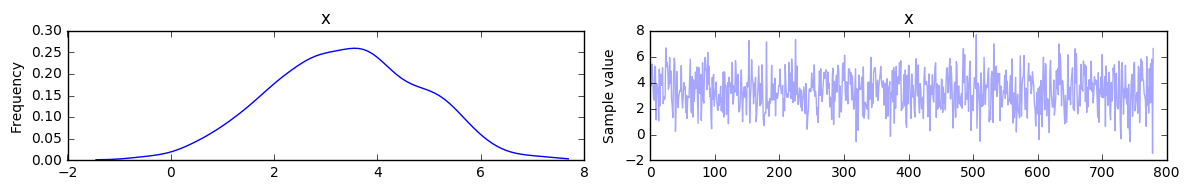

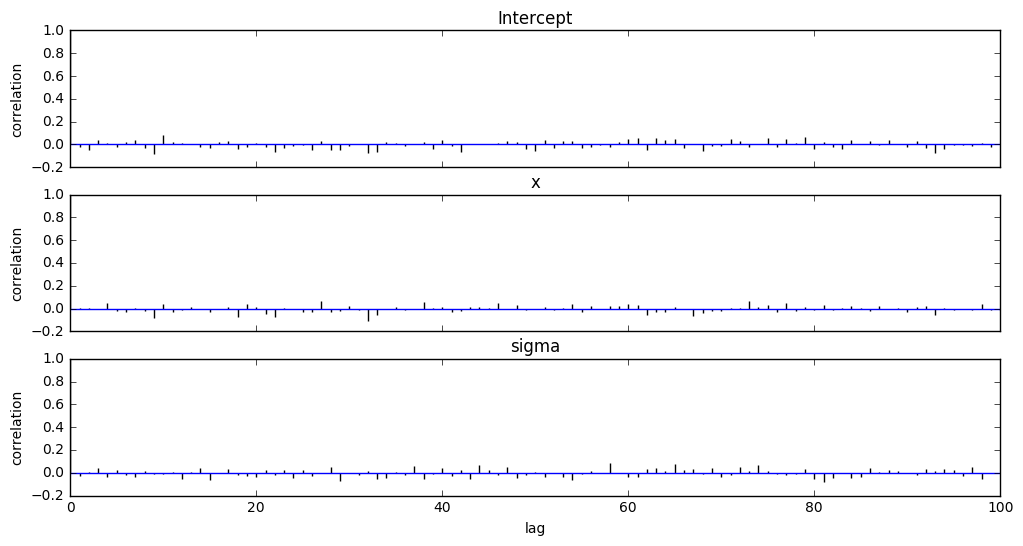

In [19]:
plt.figure(figsize=(7, 7))
pymc3.traceplot(trace[100::5],'x')
plt.tight_layout();
pymc3.autocorrplot(trace[100::5])

Let's look at a summary of the estimates.  How does the 95% highest probability density (HPD) region from the Bayesian analysis compare to the frequentist 95% confidence intervals?


In [20]:
pymc3.summary(trace[100:])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  99.401           0.984            0.025            [97.431, 101.161]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  97.498         98.707         99.412         100.124        101.257


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.364            1.416            0.036            [0.788, 6.170]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.699          2.326          3.399          4.372          6.138


sigma:

  Mean             SD               MC Error         95% HPD interval
  --------------------